In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extracting the uploaded tar file in drive itself
# import tarfile

# tar_file_path = '/content/drive/My Drive/lfw.tgz'
# extract_path = '/content/drive/My Drive/lfw'

# with tarfile.open(tar_file_path, 'r') as tar:
#     tar.extractall(extract_path)

In [2]:
from PIL import Image,ImageOps
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torchvision import models
import random
import itertools
from tqdm import tqdm
import time
# PyTorch Neural Network
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.optim as optim
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
if torch.cuda.is_available():
  device=torch.device("cuda:0")
else:
  device=torch.device("cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Specify the directory path containing subfolders
directory_path = '/content/drive/My Drive/lfw/lfw'

# Get a list of all items (files and subdirectories) in the directory
items = os.listdir(directory_path)

# Filter out only the subdirectories
celebrities = {}
cel_2=[]
for folder_name in os.listdir(directory_path):

  folder_path = os.path.join(directory_path, folder_name)
  if os.path.isdir(folder_path):

    celebrities[folder_name]=[]
    #Getting all of the images of the particular celebrity
    count=0
    for img_name in os.listdir(folder_path):
      count+=1
      img_path = folder_path + '/' + img_name
      celebrities[folder_name].append(img_path)
    #Making a list for celebrities having greater than 2 images
    if(count>=2):
      cel_2.append(folder_name)



In [ ]:
print("Celebrities with more than one Image:",len(cel_2))

Celebrities with more than one Image: 1680


In [ ]:
celebrities_2 = {key: celebrities[key] for key in cel_2}

In [ ]:
file_path1 = '/content/drive/My Drive/celeb_2.npz'
# np.savez(file_path1,**celebrities_2)
loaded_data = np.load(file_path1)

keys2_list = list(loaded_data.keys())
values2_list = [loaded_data[key].tolist() for key in loaded_data.keys()]

# Creating a dictionary for the celebrities having greater than 2 images, key being the name of the folder and values being the drive links of the images
celebrities_2 = dict(zip(keys2_list, values2_list))

## 3)

In [ ]:
#Splitting of dataset into Training,Validation,Testing (70:15:15)
keys = list(celebrities_2.keys())
values =list(celebrities_2.values())

# Split the keys and values into train, validation, and test sets
train_keys, remaining_keys, train_values, remaining_values = train_test_split(keys, values, test_size=0.3, random_state=42)
val_keys, test_keys, val_values, test_values = train_test_split(remaining_keys, remaining_values, test_size=0.5, random_state=42)

# Create train, validation, and test dictionaries
train_dict = {k: v for k, v in zip(train_keys, train_values)}
val_dict = {k: v for k, v in zip(val_keys, val_values)}
test_dict = {k: v for k, v in zip(test_keys, test_values)}

In [ ]:
print("Training Size:", len(train_dict))
print("Validation Size:", len(val_dict))
print("Testing Size:", len(test_dict))

Training Size: 1176
Validation Size: 252
Testing Size: 252


## 4)

In [ ]:
#We will be using the pretrained ResNext101 CNN model, and improvised version of resnet
resnext101=models.resnet.resnext101_32x8d(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Carlos_Ruiz


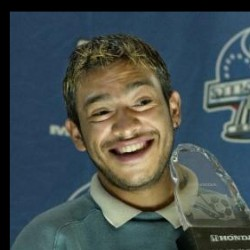

(250, 250)


In [ ]:
#Sampling random images from the dataset, just for visualization
random_celebrity = random.choice(keys)
print(random_celebrity)
img=Image.open(random.choice(celebrities_2[random_celebrity]))
display(img)
print(img.size)

## 5)

In [ ]:
#Defining a Function, to transform the image to meet resnext's requirements
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #using the standard mean and deviation used for resnext.
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])

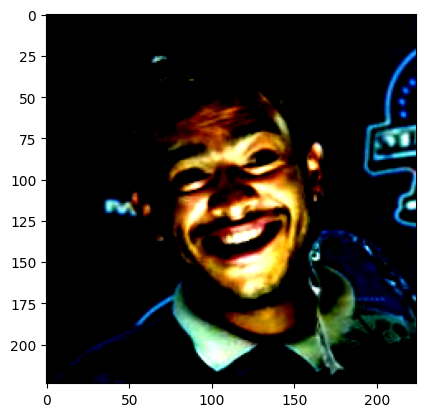

In [ ]:
plt.imshow((transform(img).numpy()).transpose(1,2,0))

In [ ]:
#Creating the decodings dictionary which simply replaces the drive links with the image arrays
# decodings={}
# i=0
# for cel_values in celebrities_2.values():
#   i+=1
#   for value in cel_values:
#     decodings[value] = np.array(Image.open(value))
#   time.sleep(0.1)
#   print(f"\rProgress: {i}/{len(celebrities_2)}", end='')

In [ ]:
file_path = '/content/drive/My Drive/celeb_decodings.npz'
# np.savez(file_path,**decodings)

In [ ]:
#Loading the image decodings previously saved (key=Folder Name, and value is a list of the image arrays)
loaded_decodings = np.load(file_path)
img_decoded = dict(loaded_decodings)

## 6)

In [ ]:
#Building a custom dataset, to make use of the deocdings to build pairs of images, equal positive and negative pairs with constraints
class PairDataset(Dataset):

  def __init__(self,dictionary,ul = 5):

    self.cels = dictionary
    #For celebrities having more than ul images, we limit them to ul images
    self.limit = ul
    #Generating pairs of drive links
    self.inp_pairs, self.targets = self.generatepairs()
    print("Pairs Generated ...")
    print("Decoding Directories to Image arrays ...")
    #Decoding the generated pairs in drive links to image arrays
    self.inpd_pairs = self.decode()
    print("Dataset Made")

  def __len__(self):
    return len(self.targets)

  def __getitem__(self,idx):
    inputidx = self.inpd_pairs[idx]
    inp1=Image.fromarray(inputidx[0])
    inp2=Image.fromarray(inputidx[1])
    #Transforming the image already to meet ResNext's requirements
    inp1=transform(inp1).to(device)
    inp2=transform(inp2).to(device)
    outputidx = torch.tensor(self.targets[idx]).to(device)

    return inp1,inp2,outputidx

  def generatepairs(self):
    #Making a list of all pairs, and corresponding targets, where 1 represents a positive pair and 0 a negative pair
    inp_pairs=[]
    targets=[]
    cel_keys = list(self.cels.keys())

    #Iterating over every celebrity to get its positive and negative sample pairs
    for cel,images in self.cels.items():

      positive_samples=images
      len_p = len(positive_samples)

      #We put an upper limit of 10 samples for a celebrity
      if( len_p > self.limit):
        positive_samples= random.sample(positive_samples, self.limit)
        len_p=self.limit

      #Making all of the positive sample pairs using pC2 combinations
      pcomb =list(itertools.combinations(positive_samples, 2))
      inp_pairs.extend(pcomb)
      targets.extend(np.ones(len(pcomb)))

      temp_keys = [k for k in cel_keys if k!=cel]

      #Randomly choosing the same number of negative samples as that of positive samples
      for i in range(len_p*(len_p-1)//2):
        random_celebrity = random.choice(temp_keys)
        negative_sample = random.choice(self.cels[random_celebrity])

        pos= random.choice(positive_samples)
        inp_pairs.append((pos,negative_sample))
        targets.append(0)
        #Making all possible positive-negative pairs
        # for pos in positive_samples:
        #   inp_pairs.append((pos,negative_sample))
        #   targets.append(0)

    return inp_pairs,targets

  def decode(self):
    #Decoding the pairs into the image arrays
    inpd_pairs=[]
    for i in range(len(self.inp_pairs)):

      temp=[]
      #We use the saved and loaded dictionary of the decodings
      temp.append(img_decoded[self.inp_pairs[i][0]])
      temp.append(img_decoded[self.inp_pairs[i][1]])
      inpd_pairs.append(temp)

      print(f"\rProgress: {i}/{len(self.inp_pairs)}", end='')

    return inpd_pairs


In [ ]:
#Building the dataset for train,validation and test with the already made dictionaries
train_dataset = PairDataset(train_dict)
val_dataset = PairDataset(val_dict)
test_dataset = PairDataset(test_dict)

Pairs Generated ...
Decoding Directories to Image arrays ...
Progress: 9807/9808Dataset Made
Pairs Generated ...
Decoding Directories to Image arrays ...
Progress: 2137/2138Dataset Made
Pairs Generated ...
Decoding Directories to Image arrays ...
Progress: 2061/2062Dataset Made


In [ ]:
print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

#Building the dataloaders, with random shuffling, and batch size as another hyperparameter.
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True)

Train Size: 9808
Validation Size: 2138
Test Size: 2062


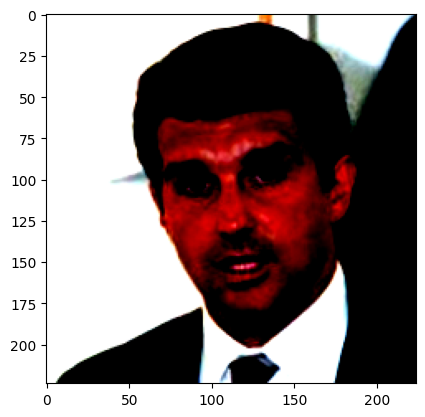

In [ ]:
#Testing the custom dataset made
x,y,z=train_dataset.__getitem__(1)
plt.imshow((y.cpu().numpy()).transpose(1,2,0))

In [ ]:
p=0
#Checking for the number of positive pairs/total number of pairs
for inp1,inp2,targets in train_dataloader:
  p+=targets.sum()
  print(f"\rProgress: {p}/{len(train_dataset)}", end='')


Progress: 4904.0/9808

32
Positive Pair


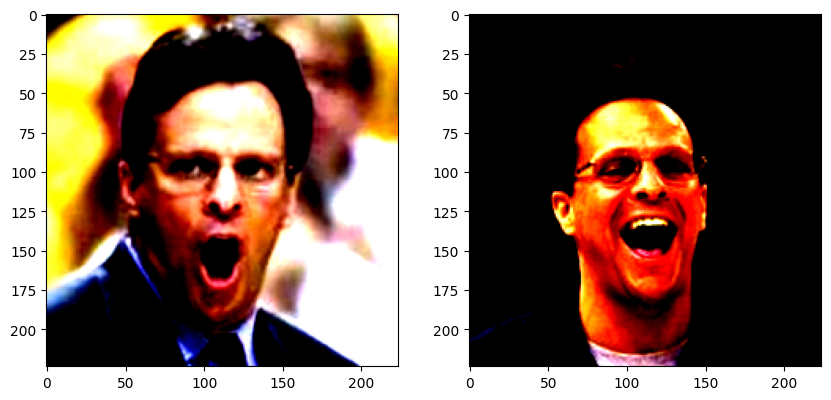

In [ ]:
#Visualizing the data, by showing the transformed images with its label
for inp1,inp2,targets in train_dataloader:
  print(len(inp1))
  if(targets[0].item()==0):
    print("Negative Pair")
  else:
    print("Positive Pair")
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow((inp1[0].cpu().numpy()).transpose(1,2,0) )
  axes[1].imshow((inp2[0].cpu().numpy()).transpose(1,2,0))
  break


#### Image Augmentation (Cropping, Horizontal Flip, Color Enhancement)

In [ ]:
#Image augmentation transformations which we introduce in some data in even epochs
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
    transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.4, hue=0.1),
    transforms.RandomCrop(188),
    transforms.Resize(224)

])


Negative Pair


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


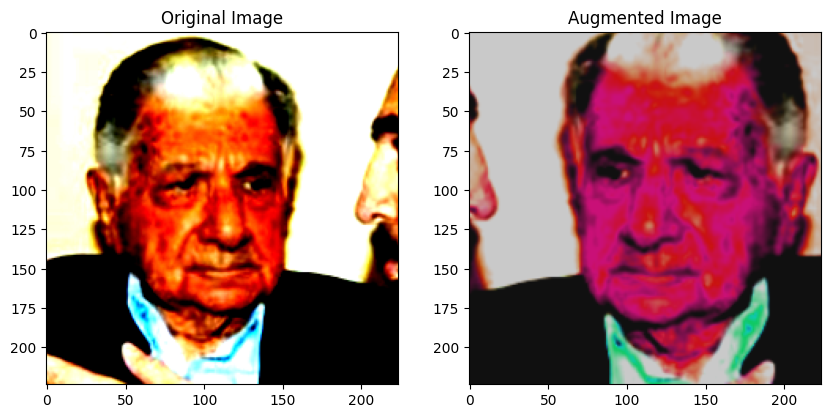

In [ ]:
#Showing the implementation of the augmented Image, we horizontally would flip the image and play with its color enhancement, and crop it
for inp1,inp2,targets in train_dataloader:
  if(targets[0].item()==0):
    print("Negative Pair")
  else:
    print("Positive Pair")
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow((inp1[0].cpu().numpy()).transpose(1,2,0) )
  axes[1].imshow((transform1(inp1[0]).cpu().numpy()).transpose(1,2,0))
  axes[0].set_title("Original Image")
  axes[1].set_title("Augmented Image")
  break

In [ ]:
#Extracting the second last layer of the resnext to get the feature vectors of dimension 2048
resnext101_features = torch.nn.Sequential(*list(resnext101.children())[:-1]).to(device)
summary(resnext101_features,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
#Defining the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Base model (ResNet in this case)
        self.resnext101_features = resnext101_features.to(device)

        #Making resnext untrainable
        for param in self.resnext101_features.parameters():
          param.requires_grad = False

        # Fully connected layers for embedding
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,128)
        ).to(device)

    def forward(self, input1, input2):
        # Forward pass for the two input images
        inp1features = self.resnext101_features(input1)
        inp2features = self.resnext101_features(input2)

        # Flatten the feature maps
        inp1features = inp1features.view(inp1features.size()[0], -1)
        inp2features = inp2features.view(inp2features.size()[0], -1)

        #feature vectors into 3 fc layers to build in the similarity
        out1=self.fc(inp1features)
        out2=self.fc(inp2features)

        # out = F.cosine_similarity(out1,out2)

        return out1,out2


## 6b) Used Dropout Layers as a regularization technique and set its hyperparameter to 0.2.

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      #Contrastive loss which works with the margin, and replaces logp from the cross entropy loss with euclidean distance
      loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                    (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

### In our Siamese Network, we would be using the **ResNext101** pretrained CNN model (A improvised Resnet model which introduces new dimension of cardinality), further we pass it to **3 FC** layers through **ReLu** and **Dropout layers** which takes care of regularization, further we calculate the similarity using **euclidean distance** and make use of **contrastive loss** with margin as a hyperparameter

In [ ]:
def train_model(num_epochs,model,train_dataloader,val_dataloader):

    #Creating lists for train loss and validation loss
    train_loss_history=[]
    val_loss_history=[]

    #Iterations over epochs
    for epoch in range(num_epochs):
        #Losses to be computed for batches
        train_loss_sum=0
        val_loss_sum=0
        train_loss=0
        val_loss=0

        #Training
        model.train()
        i=0
        for inputs1,inputs2,targets in train_dataloader:
            optimizer.zero_grad()  # Zero the gradients

            #Image Augmentation
            if(epoch%2==0):
              num_to_select = int(0.3 * len(inputs1))
               # Generate a list of random indices to augment
              random_indices = random.sample(range(len(inputs1)), num_to_select)
              inputs1[random_indices]=transform1(inputs1[random_indices])
              inputs2[random_indices]=transform1(inputs2[random_indices])

            #Getting the output from the model, calculating loss and backpropogating it
            outs1,outs2= model.forward(inputs1,inputs2)
            loss=criterion(outs1,outs2,targets)
            loss.backward()
            optimizer.step()
            train_loss_sum+=loss
            i+=1
            print(f"\rProgress: {i}/{len(train_dataloader)}", end='')


        #Validation
        model.eval()
        i=0
        for inputs1,inputs2,targets in val_dataloader:
            outputs1,outputs2= model.forward(inputs1,inputs2)
            loss=criterion(outputs1,outputs2,targets)
            val_loss_sum+=loss

        #Calculating train, validation losses
        train_loss=train_loss_sum/len(train_dataloader)
        val_loss=val_loss_sum/len(val_dataloader)
        train_loss_history.append(train_loss.detach().item())
        val_loss_history.append(val_loss.detach().item())
        print(" ")
        print(f"Epoch: {epoch + 1}")
        print(f"Training:: Loss : {train_loss}")
        print(f"Validation:: Loss : {val_loss}")

    return (train_loss_history,val_loss_history)

In [ ]:
device

device(type='cuda', index=0)

### 7) & 8)

### 1) Model: Optimizer: Adam, LRS: None

In [ ]:
model=SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
tlh,vlh = train_model(7,model,train_dataloader,val_dataloader)

Progress: 307/307 
Epoch: 1
Training:: Loss : 1.0562297150119893
Validation:: Loss : 1.2970550103267722
Progress: 307/307 
Epoch: 2
Training:: Loss : 1.063940962353213
Validation:: Loss : 1.3937065976906953
Progress: 307/307 
Epoch: 3
Training:: Loss : 1.0477577468704562
Validation:: Loss : 1.2010319822600373
Progress: 307/307 
Epoch: 4
Training:: Loss : 1.0526849167354262
Validation:: Loss : 1.2231918804202924
Progress: 307/307 
Epoch: 5
Training:: Loss : 1.045117426386031
Validation:: Loss : 1.17396025390431
Progress: 307/307 
Epoch: 6
Training:: Loss : 1.040132780162362
Validation:: Loss : 1.1696655604072084
Progress: 307/307 
Epoch: 7
Training:: Loss : 1.0488588915503534
Validation:: Loss : 1.117863830767966


In [ ]:
tlh=[1.0562297150119893,1.063940962353213,1.0477577468704562,1.0526849167354262,1.045117426386031,1.040132780162362,1.0488588915503534]
vlh=[1.2970550103267722,1.3937065976906953,1.2010319822600373,1.2231918804202924,1.17396025390431,1.1696655604072084,1.117863830767966]

In [ ]:
save_path = "/content/drive/My Drive/model1_weights.pth"

# Save the model's state_dict to the specified file
# torch.save(model.state_dict(), save_path)

In [ ]:
#Function for the testing split
def test(model,test_dataloader,thres):
  model.eval()
  predictions = []
  targets = []
  euc_d = []
  #For testing we create lists of predictions and euc_d, on the basis of euc_d and a threshold we build the predictions

  for inputs1,inputs2,labels in test_dataloader:
    out1,out2= model.forward(inputs1,inputs2)

    euclidean_dist = F.pairwise_distance(out1, out2)
    euc_d.extend(euclidean_dist)
    targets.extend(labels)

  #If distance less than threshold we declare pair to be positive else negative
  predictions = [1 if value < thres else 0 for value in euc_d]

  return predictions,euc_d,targets

  # for inputs1,inputs2,targets in test_dataloader:
  #           outputs= model.forward(inputs1,inputs2)
  #           out.extend(outputs)
  #           tar.extend(targets)
  # out = [tensor.cpu() for tensor in out]
  # out = [tensor.detach().numpy() for tensor in out]
  # tar = [tensor.cpu() for tensor in tar]
  # tar = [tensor.detach().numpy() for tensor in tar]

In [ ]:
pred,eu,tar = test(model,test_dataloader,0.62)
tar = [tensor.cpu() for tensor in tar]
tar = [tensor.detach().numpy() for tensor in tar]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(tar, pred)
f1 = f1_score(tar, pred)
precision = precision_score(tar, pred)
recall = recall_score(tar, pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.63
F1 Score: 0.53
Precision: 0.74
Recall: 0.41


In [ ]:
#Defining the training model function differently for learning rate schedulers
def train_model(num_epochs,model,train_dataloader,val_dataloader):

    #Creating lists for train loss and validation loss
    train_loss_history=[]
    val_loss_history=[]

    #Iterations over epochs
    for epoch in range(num_epochs):
        #Losses to be computed for batches
        train_loss_sum=0
        val_loss_sum=0
        train_loss=0
        val_loss=0

        #Training
        model.train()
        i=0
        for inputs1,inputs2,targets in train_dataloader:
            optimizer.zero_grad()  # Zero the gradients

            #Image Augmentation
            if(epoch%2==0):
              num_to_select = int(0.3 * len(inputs1))
               # Generate a list of random indices to augment
              random_indices = random.sample(range(len(inputs1)), num_to_select)
              inputs1[random_indices]=transform1(inputs1[random_indices])
              inputs2[random_indices]=transform1(inputs2[random_indices])

            outs1,outs2= model.forward(inputs1,inputs2)
            loss=criterion(outs1,outs2,targets)
            loss.backward()
            optimizer.step()
            train_loss_sum+=loss
            i+=1
            print(f"\rProgress: {i}/{len(train_dataloader)}", end='')

        #Implemented the learning rate scheduler
        scheduler.step()

        #Validation
        model.eval()
        i=0
        for inputs1,inputs2,targets in val_dataloader:
            outputs1,outputs2= model.forward(inputs1,inputs2)
            loss=criterion(outputs1,outputs2,targets)
            val_loss_sum+=loss

        #Calculating train, validation losses
        train_loss=train_loss_sum/len(train_dataloader)
        val_loss=val_loss_sum/len(val_dataloader)
        train_loss_history.append(train_loss.detach().item())
        val_loss_history.append(val_loss.detach().item())
        print(" ")
        print(f"Epoch: {epoch + 1}, Learning Rate: {scheduler.get_lr()}")
        print(f"Training:: Loss : {train_loss}")
        print(f"Validation:: Loss : {val_loss}")

    return (train_loss_history,val_loss_history)

### 2) Model2: Optimizer: Adam, LRS: StepLR

In [ ]:
from torch.optim.lr_scheduler import StepLR,CosineAnnealingLR
model2=SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
tlh1,vlh1 = train_model(6,model2,train_dataloader,val_dataloader)

Progress: 307/307 
Epoch: 1, Learning Rate: [0.001]
Training:: Loss : 1.0519566341576114
Validation:: Loss : 1.4300186316221206
Progress: 307/307 
Epoch: 2, Learning Rate: [0.00025]
Training:: Loss : 1.0607029842993996
Validation:: Loss : 1.3032179606067296
Progress: 307/307 
Epoch: 3, Learning Rate: [0.0005]
Training:: Loss : 1.0448404333902073
Validation:: Loss : 1.2577955311939792
Progress: 307/307 
Epoch: 4, Learning Rate: [0.000125]
Training:: Loss : 1.0341212497522374
Validation:: Loss : 1.195232706308435
Progress: 307/307 
Epoch: 5, Learning Rate: [0.00025]
Training:: Loss : 1.0238484513875914
Validation:: Loss : 1.2464813156892556
Progress: 307/307 
Epoch: 6, Learning Rate: [6.25e-05]
Training:: Loss : 1.0246894659223935
Validation:: Loss : 1.2047305962467258


In [ ]:
tlh1=[1.0519566341576114,1.0607029842993996,1.0448404333902073,1.0341212497522374,1.0238484513875914,1.0246894659223935]
vlh1=[1.4300186316221206,1.3032179606067296,1.2577955311939792,1.195232706308435,1.2464813156892556,1.2047305962467258]

In [ ]:
save_path = "/content/drive/My Drive/model2_weights.pth"

# Save the model's state_dict to the specified file
# torch.save(model2.state_dict(), save_path)

In [ ]:
#Testing on the testing dataset
pred1,eu1,tar1 = test(model2,test_dataloader,0.6)
tar1 = [tensor.cpu() for tensor in tar1]
tar1 = [tensor.detach().numpy() for tensor in tar1]

In [ ]:
accuracy = accuracy_score(tar1, pred1)
f1 = f1_score(tar1, pred1)
precision = precision_score(tar1, pred1)
recall = recall_score(tar1, pred1)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.66
F1 Score: 0.69
Precision: 0.63
Recall: 0.77


### 3) Model3: Optimizer: Adam, LRS: CosineAnnealingLR

In [ ]:
model3=SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=12)

In [ ]:
tlh2,vlh2 = train_model(6,model3,train_dataloader,val_dataloader)

Progress: 307/307 
Epoch: 1, Learning Rate: [0.000966216088617589]
Training:: Loss : 1.0520563906685494
Validation:: Loss : 1.3249226798846037


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:809: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Progress: 307/307 
Epoch: 2, Learning Rate: [0.0008856007589415737]
Training:: Loss : 1.068389837037112
Validation:: Loss : 1.325334965341266
Progress: 307/307 
Epoch: 3, Learning Rate: [0.0007808611706096958]
Training:: Loss : 1.0458566658249642
Validation:: Loss : 1.2060971902404827
Progress: 307/307 
Epoch: 4, Learning Rate: [0.0006590097423302681]
Training:: Loss : 1.0428622401946162
Validation:: Loss : 1.2258400536164227
Progress: 307/307 
Epoch: 5, Learning Rate: [0.0005282084627709408]
Training:: Loss : 1.0479449014449926
Validation:: Loss : 1.236093490144915
Progress: 307/307 
Epoch: 6, Learning Rate: [0.00039719767662021587]
Training:: Loss : 1.034128533371103
Validation:: Loss : 1.1417864356701397


In [ ]:
tlh2=[1.0520563906685494,1.068389837037112,1.0458566658249642,1.0428622401946162,1.0479449014449926,1.034128533371103]
vlh2=[1.3249226798846037, 1.325334965341266,1.2060971902404827,1.2258400536164227,1.236093490144915,1.1417864356701397]

In [ ]:
save_path = "/content/drive/My Drive/model3_weights.pth"

# Save the model's state_dict to the specified file
# torch.save(model3.state_dict(), save_path)

In [ ]:
#Testing on the testing set
pred2,eu2,tar2 = test(model3,test_dataloader,0.68)
tar2 = [tensor.cpu() for tensor in tar2]
tar2 = [tensor.detach().numpy() for tensor in tar2]

In [ ]:
accuracy = accuracy_score(tar2, pred2)
f1 = f1_score(tar2, pred2)
precision = precision_score(tar2, pred2)
recall = recall_score(tar2, pred2)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.65
F1 Score: 0.67
Precision: 0.64
Recall: 0.71


### 4) Model4: Optimizer: RMSprop, LRS: StepLR

In [ ]:
model4=SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.RMSprop(model4.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
tlh3,vlh3 = train_model(6,model4,train_dataloader,val_dataloader)

Progress: 307/307 
Epoch: 1, Learning Rate: [0.001]
Training:: Loss : 10.354990784580155
Validation:: Loss : 1.4080050951953025
Progress: 307/307 
Epoch: 2, Learning Rate: [0.00025]
Training:: Loss : 1.0368539373120966
Validation:: Loss : 1.4305823217764233
Progress: 307/307 
Epoch: 3, Learning Rate: [0.0005]
Training:: Loss : 1.032205165063727
Validation:: Loss : 1.4157535128865544
Progress: 307/307 
Epoch: 4, Learning Rate: [0.000125]
Training:: Loss : 1.03008810677959
Validation:: Loss : 1.3749976315299015
Progress: 307/307 
Epoch: 5, Learning Rate: [0.00025]
Training:: Loss : 1.02583877918438
Validation:: Loss : 1.3717771866785438
Progress: 307/307 
Epoch: 6, Learning Rate: [6.25e-05]
Training:: Loss : 1.0245395988917048
Validation:: Loss : 1.2969611042940545


In [ ]:
tlh3=[10.354990784580155,1.0368539373120966,1.032205165063727,1.03008810677959,1.02583877918438,1.0245395988917048]
vlh3=[1.4080050951953025,1.4305823217764233,1.4157535128865544,1.3749976315299015,1.3717771866785438,1.2969611042940545]

In [ ]:
save_path = "/content/drive/My Drive/model4_weights.pth"

# Save the model's state_dict to the specified file
# torch.save(model4.state_dict(), save_path)

In [ ]:
pred3,eu3,tar3 = test(model4,test_dataloader,0.5)
tar3 = [tensor.cpu() for tensor in tar3]
tar3 = [tensor.detach().numpy() for tensor in tar3]

In [ ]:
accuracy = accuracy_score(tar3, pred3)
f1 = f1_score(tar3, pred3)
precision = precision_score(tar3, pred3)
recall = recall_score(tar3, pred3)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.66
F1 Score: 0.70
Precision: 0.62
Recall: 0.79


### 5) Model5: Optimizer: RMSprop, LRS: CosineAnnealing LR

In [ ]:
model5=SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.RMSprop(model5.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=12)

In [ ]:
tlh4,vlh4= train_model(6,model5,train_dataloader,val_dataloader)

Progress: 307/307 
Epoch: 1, Learning Rate: [0.000966216088617589]
Training:: Loss : 7.274155954630678
Validation:: Loss : 1.4141494332000824
Progress: 307/307 
Epoch: 2, Learning Rate: [0.0008856007589415737]
Training:: Loss : 1.0314453276221727
Validation:: Loss : 1.3388000244980638
Progress: 307/307 
Epoch: 3, Learning Rate: [0.0007808611706096958]
Training:: Loss : 1.0419090225765637
Validation:: Loss : 1.2854334054273906
Progress: 307/307 
Epoch: 4, Learning Rate: [0.0006590097423302681]
Training:: Loss : 1.055335109590231
Validation:: Loss : 1.3505186413729129
Progress: 307/307 
Epoch: 5, Learning Rate: [0.0005282084627709408]
Training:: Loss : 1.043052007647476
Validation:: Loss : 1.212783526662259
Progress: 307/307 
Epoch: 6, Learning Rate: [0.00039719767662021587]
Training:: Loss : 1.0434291179637893
Validation:: Loss : 1.1513035688300477


In [ ]:
tlh4=[7.274155954630678,1.0314453276221727,1.0419090225765637,1.055335109590231,1.043052007647476,1.0434291179637893]
vlh4=[1.4141494332000824,1.3388000244980638,1.2854334054273906,1.3505186413729129,1.212783526662259,1.1513035688300477]

In [ ]:
pred4,eu4,tar4 = test(model5,test_dataloader,0.6)
tar4 = [tensor.cpu() for tensor in tar4]
tar4 = [tensor.detach().numpy() for tensor in tar4]

In [ ]:
accuracy = accuracy_score(tar4, pred4)
f1 = f1_score(tar4, pred4)
precision = precision_score(tar4, pred4)
recall = recall_score(tar4, pred4)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.67
F1 Score: 0.64
Precision: 0.69
Recall: 0.61


### 9)

In [ ]:
acc=[0.63,0.66,0.65,0.66,0.66]
f1=[0.53,0.69,0.67,0.7,0.64]

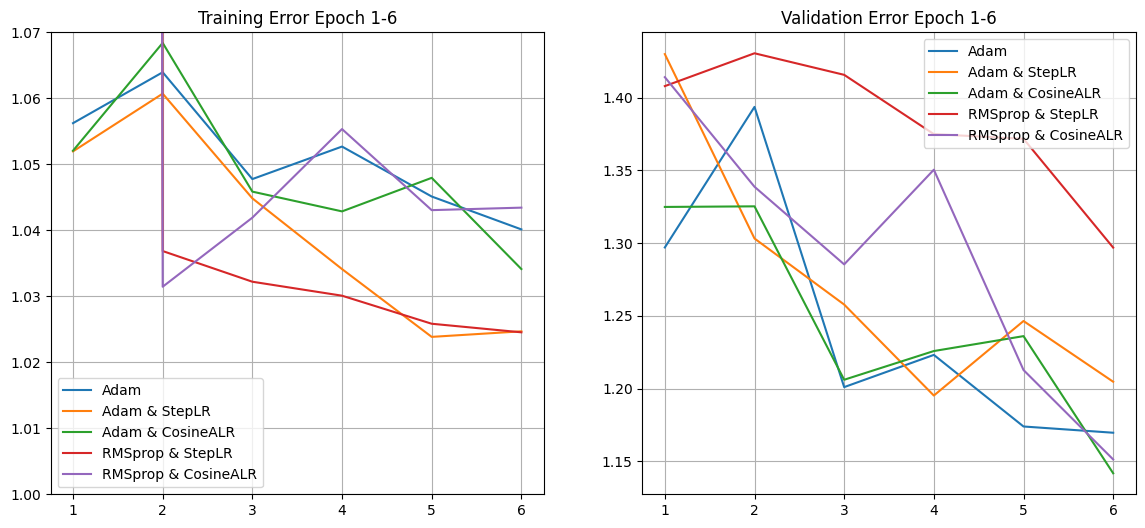

In [ ]:
#Plotting the training and validation error plots vs epochs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(np.arange(1,7,1),tlh[:-1],label='Adam')
ax1.plot(np.arange(1,7,1),tlh1,label='Adam & StepLR')
ax1.plot(np.arange(1,7,1),tlh2,label='Adam & CosineALR')
ax1.plot(np.arange(1,7,1),tlh3,label='RMSprop & StepLR')
ax1.plot(np.arange(1,7,1),tlh4,label='RMSprop & CosineALR')
ax1.set_ylim(1,1.07)
ax1.grid()
ax1.set_title("Training Error Epoch 1-6")
ax1.legend()
ax2.plot(np.arange(1,7,1),vlh[:-1],label='Adam')
ax2.plot(np.arange(1,7,1),vlh1,label='Adam & StepLR')
ax2.plot(np.arange(1,7,1),vlh2,label='Adam & CosineALR')
ax2.plot(np.arange(1,7,1),vlh3,label='RMSprop & StepLR')
ax2.plot(np.arange(1,7,1),vlh4,label='RMSprop & CosineALR')
# ax2.set_ylim(1,1.07)
ax2.grid()
ax2.set_title("Validation Error Epoch 1-6")
ax2.legend()


### Due to Limited Resources, and a epoch taking roughly 7 minutes, the no. of epochs were limites, the performance has not yet been saturated but due to resources we had to limit the no. of epochs, this could cause wrong interpretation of models.
### The Training Error is falling down for all, and is least for RMSprop and Adam optimizer with the learning rate scheduler as StepLR. It can also be observed that the training error when using RMSprop is very high in the first epoch but falls down suddenly later.

### The validation error is always higher than that of the training error, though the validation loss is closer for all , it is least for the cosineannealing LR scheduler

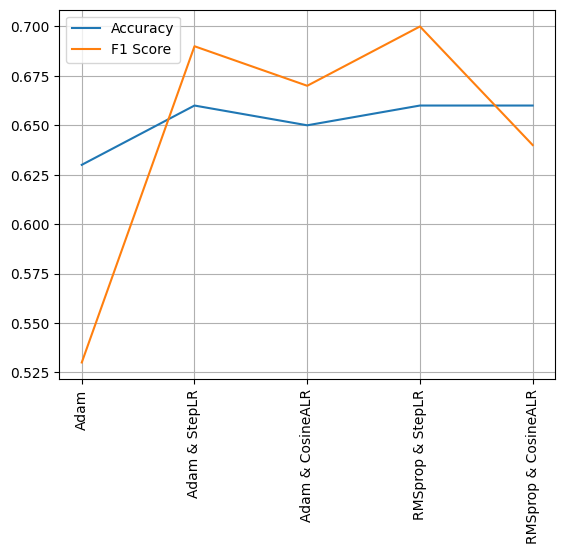

In [ ]:
#PLotting the metrics namely accuracy and f1 score for every epochs
combinations = ['Adam', 'Adam & StepLR', 'Adam & CosineALR', 'RMSprop & StepLR', 'RMSprop & CosineALR']
plt.plot(np.arange(1,6,1),acc,label='Accuracy')
plt.plot(np.arange(1,6,1),f1,label='F1 Score')
plt.xticks(np.arange(1,6,1), combinations, rotation=90)
plt.legend()
plt.grid()
plt.show()

### It can be seen that the model performs the best when the optimizer is RMSprop and the learning rate scheduler is STepLR, though it can also be seen all of the values are very close. But when using only adam without any learning rate scheduler our accuracy and F1 score falls down
### We can conclude our model with RMSprop and StepLR to be best followed by Adam and StepLR

### SteplLR provided a stable and a predictable learning rate reduction.

In [ ]:
best_model=SiameseNetwork().to(device)
torch.save(best_model.state_dict(), '/content/drive/My Drive/model4_weights.pth')

In [ ]:
predb,eub,tarb = test(best_model,test_dataloader,0.4)
tarb = [tensor.cpu() for tensor in tarb]
tarb = [tensor.detach().numpy() for tensor in tarb]

In [ ]:
def test_one_pair(img1,img2, model):
  model.eval()
  #transform the individual images
  img1 = transform(img1)
  img2 = transform(img2)
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow((img1.numpy()).transpose(1,2,0))
  axes[1].imshow((img2.numpy()).transpose(1,2,0))
  axes[0].set_title("1st Image")
  axes[1].set_title("2nd Image")
  #Match with batch size to forward
  img1 = img1.unsqueeze(0)
  img2 = img2.unsqueeze(0)

  img1, img2 = img1.cuda(), img2.cuda()
  out1, out2 = model.forward(img1,img2)

  euclidean_dist = F.pairwise_distance(out1, out2)

  #on the basis of threshold classify pairs as positive or negative
  if(euclidean_dist < 0.35):
    prediction=1
    print("Positive Pair")
  else:
    prediction=0
    print("Negative pair")
  print(prediction)
  print("Euclidean distance:",euclidean_dist.item())
  return prediction,euclidean_dist

In [ ]:
img1=Image.open('/content/drive/My Drive/me1.jpeg')
img2=Image.open('/content/drive/My Drive/me2.jpeg')
img3=Image.open('/content/drive/My Drive/notme2.jpeg')

### 10)

# Part **B**

In [ ]:
print(len(img_decoded))

9164


In [ ]:
#Making a list of images (5000 samples)
imagestotal_list = list(img_decoded.values())
images_list=random.sample(imagestotal_list,5000)

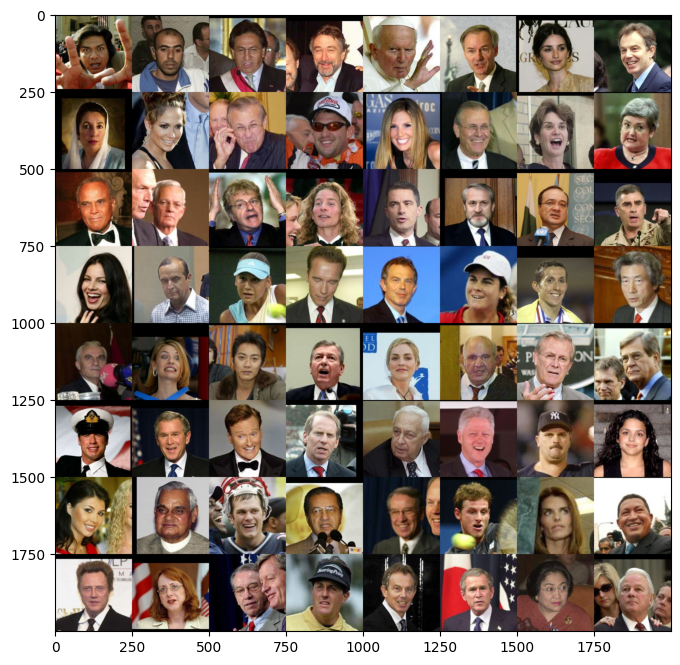

In [ ]:
#Visualizing the data
def gallery(array, ncols=8):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    #Changing image for pltl.imshow requirements
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array():
    arr = []
    # Randomly select 64 images to visualize
    for i in range(64):
        random_image = random.choice(images_list)
        arr.append(np.asarray(random_image))
    return np.array(arr)

#Showing 64 images randomly in a grid of the dataset
array = make_array()
result = gallery(array)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.show()

In [ ]:
#Transforming the image by resizing it into 128*128 making it lesser expensive, and further normalizing it
transform = transforms.Compose([transforms.Resize(128),
                                transforms.CenterCrop(128),
                                transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])
#Denormalization transformation
denorm = transforms.Compose([
     transforms.Normalize(mean=[-0.485,-0.456,-0.406],std=[1/0.229, 1/0.224, 1/0.225])])


In [ ]:
#Building a simple custom dataset, which gives transformed image
class ImageDataset(Dataset):
  def __init__(self,images_list ):
    self.images_list = images_list

  def __len__(self):
    return len(self.images_list)

  def __getitem__(self, index):
    image= Image.fromarray(images_list[index])
    image = transform(image)
    return image

In [ ]:
#Building the train data
train_data=ImageDataset(images_list)
train_Dataloader= DataLoader(train_data, batch_size=32, shuffle=True)

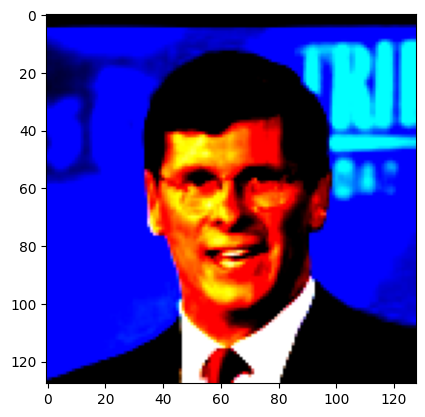

In [ ]:
#testing the traindataset
plt.imshow(train_data.__getitem__(2).numpy().transpose(1,2,0))

In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        #We would be generating 128*128 images in RGB channel thus would need 6 Convtranspose layers
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),     # 4*4
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),   #8*8
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),  #16*16
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),   #32*32
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),   #64*64
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()   #128*128
        )

    def forward(self,x):
        #Outputting a 3*128*128 image
        x = self.main(x)
        return x

In [ ]:
GeneratorI=Generator(128).to(device)

In [ ]:
#generating random noise according to the batch size of 32, and image size of 128*128
noise = torch.randn(32, 128, 1, 1).to(device)

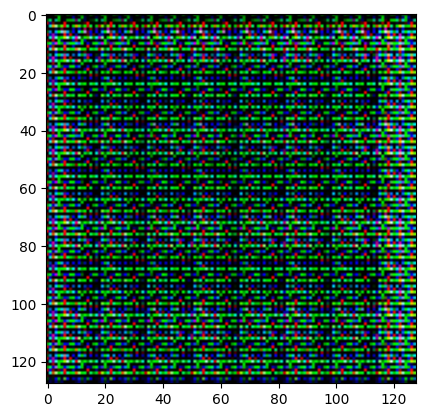

In [ ]:
#Testing our Generator, it is obvious it would generate a bad image as the weights are not trained yet
fake_images=GeneratorI(noise)
plt.imshow(fake_images[0].detach().cpu().numpy().transpose(1,2,0))

In [ ]:
from torchvision.utils import make_grid
#Defining a function to show 64 images in a grid, from the output received from the generator
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).cpu().permute(1, 2, 0))


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        #The main block which reduces dimensions to give one output (just to identify if the image is fake or not)
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1), #128*128
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1), #64*64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1), #32*32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1), #16*16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1), #8*8
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=1024  , out_channels=1, kernel_size=4, stride=2, padding=0), #4*4
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.main(x)
        return x

In [ ]:
DiscriminatorI=Discriminator().to(device)

In [ ]:
#We use adam optimizers for both discriminator and the generator
optimizerd = optim.Adam(DiscriminatorI.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerg = optim.Adam(GeneratorI.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#We use the binary cross entropy loss for both the real and fake loss
#the total loss of would be real + fake loss
loss_fn = nn.BCELoss()
#defininf functions for real loss and fake loss 
def Real_loss(preds,targets):
    #drawing label noise from a beta distribution
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds-label_noise)
    return loss

def Fake_loss(preds,targets):
    #ddrawing label noise from the beta distribution
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds+label_noise)
    return loss

In [ ]:
#Batch size is 32, and latent size which is nothing but the noise size is 128
batch_size=32
latent_size=128
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

def train(D, G,epochs):
    iter_count = 0
    start_idx=1
    for epoch in range(epochs):
        j=0
        for real_images in train_Dataloader:
            j+=1
            real_images=real_images.to(device)

            # Pass real images through discriminator
            D_out_real = D(real_images)
            label_real = torch.full(D_out_real.shape, 1.0).to(torch.device(device))
            real_loss = Real_loss(label_real,D_out_real)
            real_score = torch.mean(D_out_real).item()

            # Generate fake images
            noise = torch.randn(batch_size, latent_size, 1, 1).to(torch.device(device))
            fake_images =  G(noise)

            # Pass fake images through discriminator
            D_out_fake = D(fake_images)
            label_fake =  torch.full(D_out_fake.shape, 0).to(torch.device(device))
            fake_loss = Fake_loss(label_fake, D_out_fake)
            fake_score = torch.mean(D_out_fake).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss

            optimizerd.zero_grad()
            loss_d.backward(retain_graph = True)
            optimizerd.step()

            # Generate fake images
            noise2 = torch.randn(batch_size, latent_size, 1, 1).to(torch.device(device))
            fake_images2 =  G(noise2)

            gen_steps = 1
            for i in range(0, gen_steps ):
            # Try to fool the discriminator
                D_out_fake2 = D(fake_images2)

                # The label is set to 1(real-like) to fool the discriminator
                label_real1 = torch.full(D_out_fake2.shape, 1.0).to(torch.device(device))
                loss_g = Real_loss(label_real1, D_out_fake2)

                # Update generator weights
                optimizerg.zero_grad()
                loss_g.backward(retain_graph = (i<gen_steps -1 ))
                optimizerg.step()

            print(f"\rProgress: {j}/{len(train_Dataloader)}", end='')


        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Log losses & scores (last batch)
        print(" ")
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

In [ ]:
#Training the Generator and Dicriminator for 60 epochs
train(DiscriminatorI,GeneratorI,60)

Progress: 157/157 
Epoch [1/60], loss_g: 0.5595, loss_d: 0.0896, real_score: 0.9765, fake_score: 0.1636
Progress: 157/157 
Epoch [2/60], loss_g: 0.7111, loss_d: 0.0881, real_score: 0.8985, fake_score: 0.0133
Progress: 157/157 
Epoch [3/60], loss_g: 0.7027, loss_d: 0.3880, real_score: 0.9719, fake_score: 0.6200
Progress: 157/157 
Epoch [4/60], loss_g: 0.4457, loss_d: 0.0890, real_score: 0.9004, fake_score: 0.1426
Progress: 157/157 
Epoch [5/60], loss_g: 0.7133, loss_d: 0.0624, real_score: 0.9167, fake_score: 0.0000
Progress: 157/157 
Epoch [6/60], loss_g: 0.5219, loss_d: 0.0538, real_score: 0.8402, fake_score: 0.1500
Progress: 157/157 
Epoch [7/60], loss_g: 0.4624, loss_d: 0.1636, real_score: 0.8822, fake_score: 0.5164
Progress: 157/157 
Epoch [8/60], loss_g: 0.5945, loss_d: 0.0623, real_score: 0.7888, fake_score: 0.0551
Progress: 157/157 
Epoch [9/60], loss_g: 0.2148, loss_d: 0.1389, real_score: 0.5838, fake_score: 0.2328
Progress: 157/157 
Epoch [10/60], loss_g: 0.7000, loss_d: 0.1709

In [ ]:
#Random Noise to generate fake images
noise1 = torch.randn(32, 128, 1, 1).to(device)
#Generating fake images using the noise
fake_images=GeneratorI(noise1)

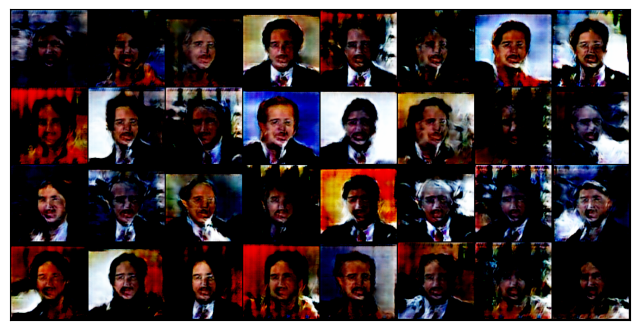

In [ ]:
#Showing the fake images generated
show_images((fake_images))

### As above can be seen the generator has worked quiet well, by running it for 60 epochs. Due to time resources and limited resource availability this is what i could get.

# **BONUS**

## To Implement a CGAN we will have to add in labels to the generator, discriminator and the loss function, this can be done by concatenating the image feature vector to the noise to generate, and as reference in the discriminator and the loss.

In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        #We would be generating 128*128 images in RGB channel thus would need 6 Convtranspose layers
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),     # 4*4
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),   #8*8
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),  #16*16
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),   #32*32
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),   #64*64
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()   #128*128
        )

    def forward(self,x):
        #Outputting a 3*128*128 image
        x = self.main(x)
        return x